# Reading CSV file & Identifying columns that cause leakage
Using data collected after the show would be cheating and while they will give good results according to train data but will be failure in production. 
Hence , we dont use them 

In [491]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [492]:
df = pd.read_csv("tour_logs_train.csv")
df

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58
3,Gig_0003,V_Beta,08/07/2024 8:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Gig_1995,V_Alpha,2024-06-16 20:00:00,6,NaN,57.34,699.0,5,Stormy,First Quarter,Denim,601,40.67
1996,Gig_1996,V_Beta,05-23-2024 23:00,3,7.0,26.94,588.0,5,Stormy,Full Moon,Spandex,897,65.60
1997,Gig_1997,V_Beta,Late Night,4,2.0,57.54,649.0,1,Rainy,Waning Gibbous,Leather,670,60.34
1998,Gig_1998,V_Beta,"May 28, 2024",1,9.0,53.37,503.0,1,Rainy,Waning Gibbous,Leather,597,150.00


In [ ]:
# Gig_ID                - Just a ID - NOT USEFUL
# Venue_ID              - Known Before Show
# Show_DateTime         - Known Before Show
# Day_of_Week           - Can be found out from the column before it  
# Volume_Level          - Known Before Show
# Ticket_Price          - Known Before Show
# Crowd_Size            - CANT BE KNOWN BEFORE SHOW (LEAKAGE) - DONT USE TO TRAIN
# Opener_Rating         - Known Before Show
# Weather               - Known Before Show
# Moon_Phase            - Known Before Show
# Band_Outfit           - Known Before Show
# Merch_Sales_Post_Show - CANT BE KNOWN BEFORE SHOW (LEAKAGE) - DONT USE TO TRAIN
# Crowd_Energy          - TO FIND BY REGRESSION

# Data Cleaning

In [ ]:
df.isna().sum()

##### Crowd Energy 
As these crowd energy are out of range (0-100) , we cannot use them for training. 
So we remove these rows entirely 

In [493]:
df = df[(df['Crowd_Energy'] >= 0) & (df['Crowd_Energy'] <= 100)]
df

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58
3,Gig_0003,V_Beta,08/07/2024 8:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,Gig_1994,V_Beta,18/08/2024 08:00 PM,6,4.0,62.86,432.0,4,Cloudy,Waxing Gibbous,Denim,942,61.32
1995,Gig_1995,V_Alpha,2024-06-16 20:00:00,6,NaN,57.34,699.0,5,Stormy,First Quarter,Denim,601,40.67
1996,Gig_1996,V_Beta,05-23-2024 23:00,3,7.0,26.94,588.0,5,Stormy,Full Moon,Spandex,897,65.60
1997,Gig_1997,V_Beta,Late Night,4,2.0,57.54,649.0,1,Rainy,Waning Gibbous,Leather,670,60.34


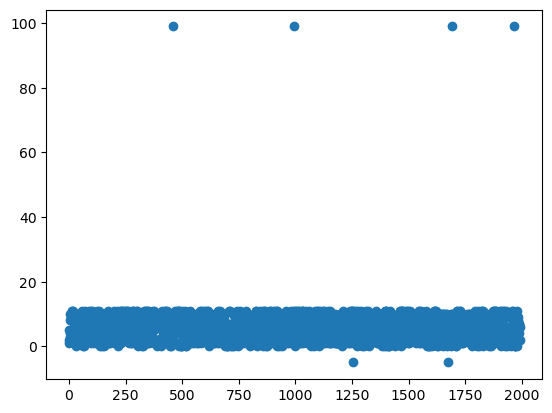

In [494]:
plt.scatter(range(len(df)), df['Volume_Level'])

##### Volume level 
We first convert all values lying outside the range to Nan then replace them by their median venue wise 

In [495]:
df.loc[df['Volume_Level'] <= 0, 'Volume_Level'] = np.nan
df.loc[df['Volume_Level'] > 11, 'Volume_Level'] = np.nan

In [496]:
venue = df['Venue_ID'].unique()
for v in venue:
    m = df[df['Venue_ID']==v]['Volume_Level'].median()
    df.loc[df['Venue_ID']==v,'Volume_Level'] = df.loc[df['Venue_ID']==v,'Volume_Level'].fillna(m)

##### Crowd Size
We first convert all values lying outside the range to Nan then replace them by their median venue wise 

In [497]:
df.loc[df['Crowd_Size'] < 0,'Crowd_Size'] = np.nan
df.loc[df['Crowd_Size'] > 1000,'Crowd_Size'] = np.nan

In [498]:
venue = df['Venue_ID'].unique()
for v in venue:
    m = df[df['Venue_ID']==v]['Crowd_Size'].median()
    df.loc[df['Venue_ID']==v,'Crowd_Size'] = df.loc[df['Venue_ID']==v,'Crowd_Size'].fillna(m)

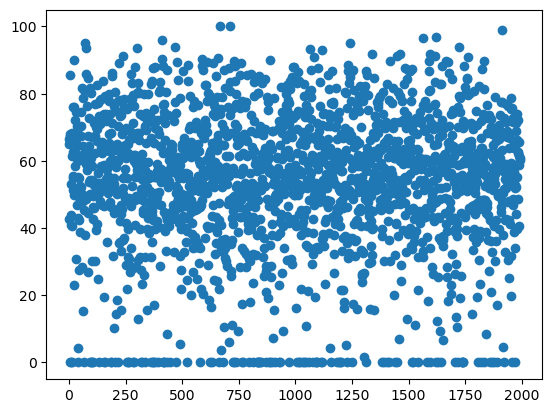

In [499]:
plt.scatter(range(len(df)),df['Crowd_Energy'])

##### Cleaning 'Show_DateTime'


In [500]:
df['Show_DateTime_real'] = df['Show_DateTime'].copy()
for i in df.index:
    DateTime = str(df.loc[i, 'Show_DateTime_real'])
    try:
        df.loc[i,'Show_DateTime']=pd.to_datetime(DateTime)
    except:
        try:
            df.loc[i,'Show_DateTime']=pd.to_datetime(DateTime, format='%d/%m/%Y %I:%M %p')
        except:
            try:
                df.loc[i,'Show_DateTime']=pd.to_datetime(DateTime, format='%m-%d-%Y %H:%M')
            except:
                try:
                    df.loc[i,'Show_DateTime']=pd.to_datetime(DateTime, format='%B %d, %Y')
                except:
                    if 'late night' in DateTime.lower():
                        df.loc[i,'Show_DateTime'] = pd.to_datetime('2024-06-01 23:00:00')
                    elif 'evening' in DateTime.lower():
                        df.loc[i,'Show_DateTime'] = pd.to_datetime('2024-06-01 20:00:00')
                    elif 'afternoon' in DateTime.lower():
                        df.loc[i,'Show_DateTime'] = pd.to_datetime('2024-06-01 15:00:00')
                    elif 'morning' in DateTime.lower():
                        df.loc[i,'Show_DateTime'] = pd.to_datetime('2024-06-01 10:00:00')


C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\1283759268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Show_DateTime_real'] = df['Show_DateTime'].copy()
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\1283759268.py:5: UserWarning: Parsing dates in %d/%m/%Y %I:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.loc[i,'Show_DateTime']=pd.to_datetime(DateTime)
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\1283759268.py:5: UserWarning: Parsing dates in %d/%m/%Y %I:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.loc[i,'Show_DateTime']=pd.to_datetime(DateTime)
C:\Users\LOQ\Ap

In [501]:
plt.scatter(range(len(df)), df['Ticket_Price_USD'])

KeyError: 'Ticket_Price_USD'

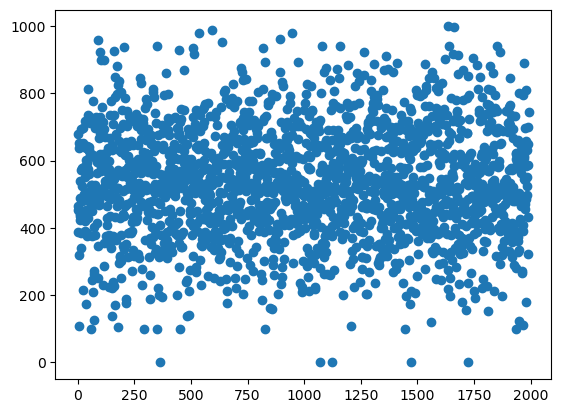

In [502]:
plt.scatter(range(len(df)), df['Crowd_Size'])

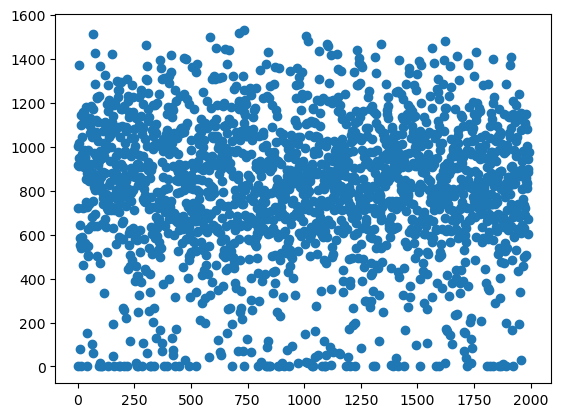

In [503]:
plt.scatter(range(len(df)), df['Merch_Sales_Post_Show'])

<Axes: >

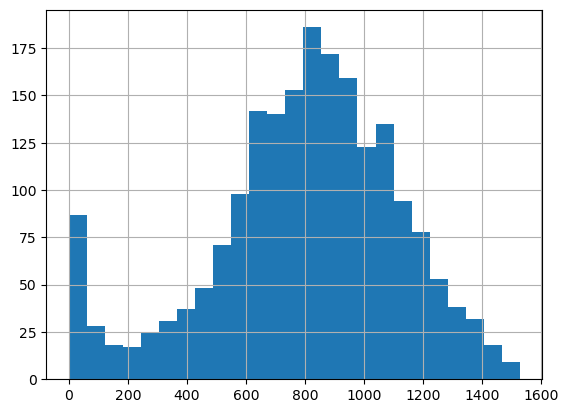

In [504]:
df['Merch_Sales_Post_Show'].hist(bins=25)

##### Cleaning Ticket Price and making a new Column 'Ticket_Price_USD'

In [505]:
df['Ticket_Price_original'] = df['Ticket_Price']
prices = []
for price in df['Ticket_Price']:
    if pd.isna(price):
        prices.append(None)
        continue
    price_str = str(price).strip().lower() 
    if 'free' in price_str:
        prices.append(0)
        continue 
    numbers = re.findall(r'\d+\.?\d*', price_str)
    if not numbers:
        prices.append(None)
        continue 
    value = float(numbers[0])    
    if '£' in price_str:
        prices.append(value * 1.27)
    elif '€' in price_str:
        prices.append(value * 1.09)
    else:
        prices.append(value)
df['Ticket_Price_USD'] = prices

C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\3775553899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ticket_Price_original'] = df['Ticket_Price']
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\3775553899.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ticket_Price_USD'] = prices


# EDA


In [506]:
df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'], errors='coerce')
df['weekday'] = df['Show_DateTime'].dt.day_name()
df.groupby('weekday')['Crowd_Energy'].mean().sort_values()

C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\3929001953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'], errors='coerce')
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\3929001953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Show_DateTime'].dt.day_name()


weekday
Wednesday    50.811770
Friday       50.841325
Monday       52.293077
Tuesday      52.738567
Thursday     53.469425
Saturday     53.629344
Sunday       58.360976
Name: Crowd_Energy, dtype: float64

In [507]:
df.isna().sum()

Gig_ID                   0
Venue_ID                 0
Show_DateTime            0
Day_of_Week              0
Volume_Level             0
Ticket_Price             0
Crowd_Size               0
Opener_Rating            0
Weather                  0
Moon_Phase               0
Band_Outfit              0
Merch_Sales_Post_Show    0
Crowd_Energy             0
Show_DateTime_real       0
Ticket_Price_original    0
Ticket_Price_USD         0
weekday                  0
dtype: int64

### Weekday 

 
 The singer claims that tuesdays are cursed BUT that doesnt seem to be the case for V_Alpha , V_Gamma , V_Delta.
 In these venues Tuesdays perform average                                                                                                 
 For V_Beta , Tuesdays along with Wednesday both performed poor


<Axes: title={'center': 'Crowd_Energy'}, xlabel='weekday'>

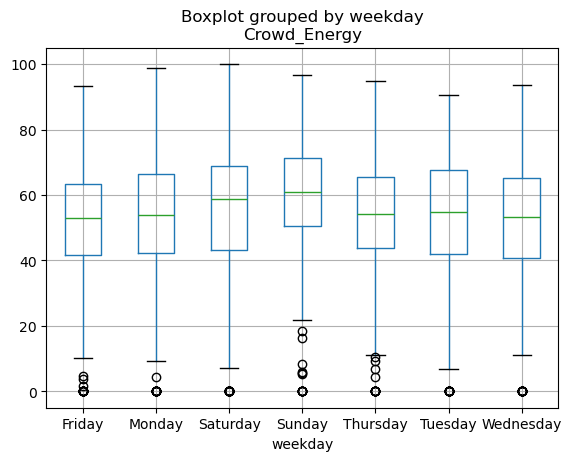

In [508]:
df.boxplot(column='Crowd_Energy', by='weekday')

In [509]:
# For V_Alpha
weekday_energy_V_Alpha = df[df['Venue_ID'] == 'V_Alpha'].groupby('weekday')['Crowd_Energy']
avg_weekday_energy_V_Alpha = weekday_energy_V_Alpha.mean().sort_values()
avg_weekday_energy_V_Alpha

weekday
Tuesday      44.098533
Monday       45.853939
Friday       47.634737
Wednesday    48.910833
Thursday     49.460690
Saturday     50.498108
Sunday       52.704744
Name: Crowd_Energy, dtype: float64

<BarContainer object of 7 artists>

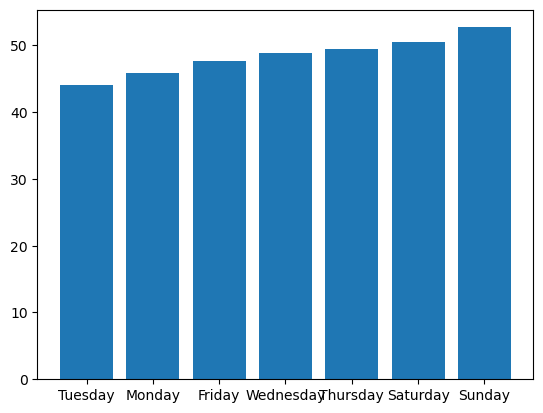

In [510]:
plt.bar(avg_weekday_energy_V_Alpha.index, avg_weekday_energy_V_Alpha.values)

In [511]:
# For V_Beta
weekday_energy_V_Beta = df[df['Venue_ID'] == 'V_Beta'].groupby('weekday')['Crowd_Energy']
avg_weekday_energy_V_Beta = weekday_energy_V_Beta.mean().sort_values()
avg_weekday_energy_V_Beta

weekday
Wednesday    29.500600
Monday       37.205312
Tuesday      37.277500
Thursday     39.674697
Saturday     40.152190
Friday       41.584819
Sunday       48.142542
Name: Crowd_Energy, dtype: float64

<BarContainer object of 7 artists>

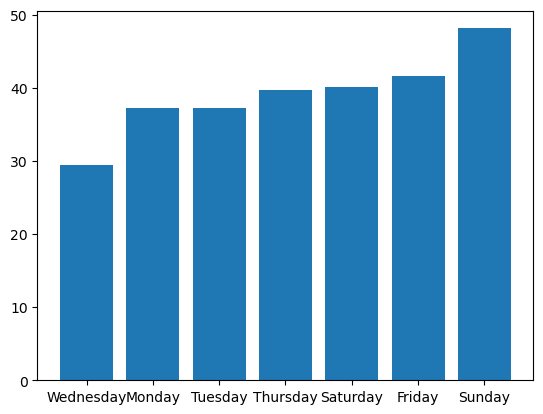

In [512]:
plt.bar(avg_weekday_energy_V_Beta.index, avg_weekday_energy_V_Beta.values)

In [513]:
# For V_Gamma
weekday_energy_V_Gamma = df[df['Venue_ID'] == 'V_Gamma'].groupby('weekday')['Crowd_Energy']
avg_weekday_energy_V_Gamma = weekday_energy_V_Gamma.mean().sort_values()
avg_weekday_energy_V_Gamma

weekday
Friday       62.846066
Wednesday    66.490156
Tuesday      68.154247
Monday       69.467571
Thursday     69.574286
Sunday       69.642500
Saturday     72.740000
Name: Crowd_Energy, dtype: float64

<BarContainer object of 7 artists>

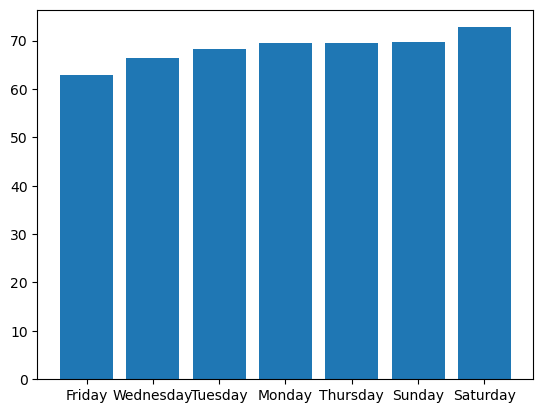

In [514]:
plt.bar(avg_weekday_energy_V_Gamma.index, avg_weekday_energy_V_Gamma.values)

In [515]:
# For V_Delta
weekday_energy_V_Delta = df[df['Venue_ID'] == 'V_Delta'].groupby('weekday')['Crowd_Energy']
avg_weekday_energy_V_Delta = weekday_energy_V_Delta.mean().sort_values()
avg_weekday_energy_V_Delta

weekday
Wednesday    53.365362
Friday       54.252317
Monday       54.483605
Thursday     55.203919
Tuesday      57.103483
Saturday     57.554638
Sunday       60.383143
Name: Crowd_Energy, dtype: float64

<BarContainer object of 7 artists>

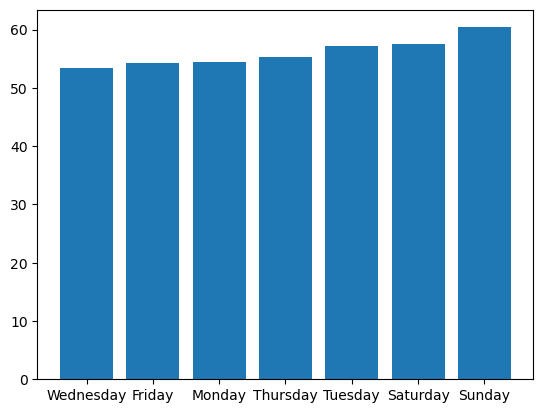

In [516]:
plt.bar(avg_weekday_energy_V_Delta.index, avg_weekday_energy_V_Delta.values)

### The monks at one of the venues... or was it the goths? Someone has a noise limit. 
Brother Thomas - the old one with the massive beard - he WINCES at 
a certain volume. Once he winces, it's over. The energy just dies. But 
here's what's weird: I've ALSO seen him tolerate absolute chaos when the 
place was packed to the rafters. Maybe he just gives up enforcing when 
there's too many people? Or maybe he's deaf in one ear and it depends 
which way he's facing? Or maybe I'm thinking of a completely different 
venue. The tours blur together, man.

In [517]:
energy_volume = df.groupby(['Venue_ID', 'Volume_Level'])['Crowd_Energy'].mean()
energy_volume

Venue_ID  Volume_Level
V_Alpha   1.0             60.600323
          2.0             60.714884
          3.0             60.137879
          4.0             41.206861
          5.0             61.611176
          6.0             62.448421
          7.0             69.680000
V_Beta    1.0             40.170952
          2.0             37.800000
          3.0             38.969787
          4.0             36.291053
          5.0             34.969565
          6.0             41.773023
          7.0             47.584651
          8.0             37.420294
          9.0             33.880652
          10.0            42.096279
          11.0            43.052600
V_Delta   1.0             47.864259
          2.0             48.545600
          3.0             51.571800
          4.0             52.586087
          5.0             56.793611
          6.0             52.434561
          7.0             55.462105
          8.0             59.627273
          9.0             62.229787
     

<Axes: xlabel='Venue_ID,Volume_Level'>

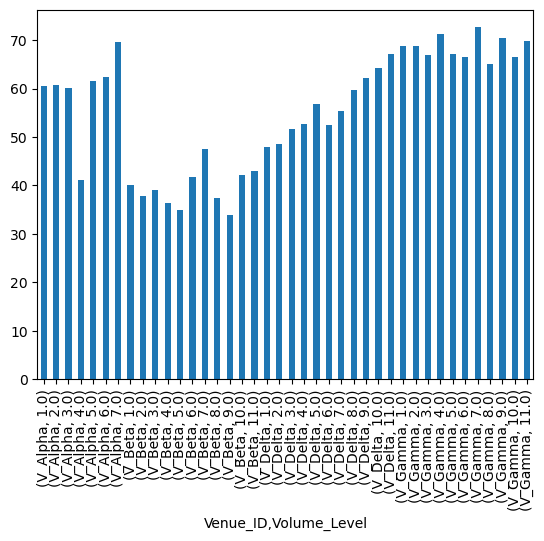

In [518]:
energy_volume.plot(kind='bar')

In [519]:
#
df.groupby('Venue_ID')[['Volume_Level','Crowd_Energy']].corr()

Volume_Level  Crowd_Energy
Venue_ID                                         
V_Alpha  Volume_Level      1.000000     -0.146051
         Crowd_Energy     -0.146051      1.000000
V_Beta   Volume_Level      1.000000      0.038165
         Crowd_Energy      0.038165      1.000000
V_Delta  Volume_Level      1.000000      0.393879
         Crowd_Energy      0.393879      1.000000
V_Gamma  Volume_Level      1.000000      0.000512
         Crowd_Energy      0.000512      1.000000

### Moon Phase
##### FULL MOON = MAGIC 🌕
I am CONVINCED our best shows happen during full moons. The energy is 
just... different. Electric. The crowd moves like they're possessed. 


In [520]:
# overall
avg_moon_energy= df.groupby('Moon_Phase')['Crowd_Energy'].mean().sort_values()
avg_moon_energy

Moon_Phase
Waning Crescent    51.301435
New Moon           52.092100
First Quarter      52.897365
Last Quarter       53.385000
Full Moon          53.483198
Waxing Crescent    53.535000
Waning Gibbous     54.110076
Waxing Gibbous     54.887842
Name: Crowd_Energy, dtype: float64

In [521]:
# For V_Delta
moon_energy_V_Delta =df[df['Venue_ID'] == 'V_Delta'].groupby('Moon_Phase')['Crowd_Energy']
# Taking Average
avg_moon_energy_V_Delta = moon_energy_V_Delta.mean().sort_values()
avg_moon_energy_V_Delta

Moon_Phase
New Moon           54.024184
Waning Gibbous     54.788507
First Quarter      55.018852
Waning Crescent    55.552222
Waxing Crescent    56.751212
Waxing Gibbous     57.368868
Full Moon          57.601167
Last Quarter       58.364032
Name: Crowd_Energy, dtype: float64

Text(0, 0.5, 'Average Crowd Energy')

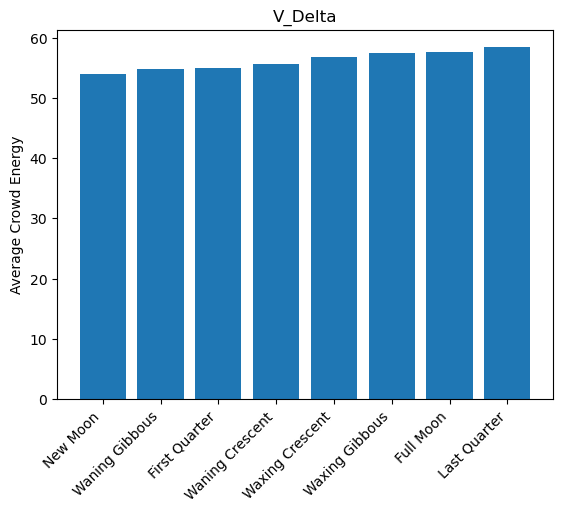

In [522]:
plt.bar(avg_moon_energy_V_Delta.index, avg_moon_energy_V_Delta.values)
plt.xticks(rotation=45, ha='right')
plt.title('V_Delta')
plt.ylabel('Average Crowd Energy')

In [523]:
# For V_Alpha
moon_energy_V_Alpha =df[df['Venue_ID'] == 'V_Alpha'].groupby('Moon_Phase')['Crowd_Energy']
# Taking Average
avg_moon_energy_V_Alpha = moon_energy_V_Alpha.mean().sort_values()
avg_moon_energy_V_Alpha

Moon_Phase
Full Moon          45.635085
First Quarter      47.812778
Waxing Crescent    47.883125
Last Quarter       48.160484
Waning Gibbous     48.822687
Waning Crescent    49.251569
New Moon           49.450000
Waxing Gibbous     51.417600
Name: Crowd_Energy, dtype: float64

In [524]:
# For V_Beta
moon_energy_V_Beta =df[df['Venue_ID'] == 'V_Beta'].groupby('Moon_Phase')['Crowd_Energy']
# Taking Average
avg_moon_energy_V_Beta = moon_energy_V_Beta.mean().sort_values()
avg_moon_energy_V_Beta

Moon_Phase
Waning Crescent    32.874182
Last Quarter       36.042105
Waxing Gibbous     37.029231
Waxing Crescent    39.690323
New Moon           40.284595
Full Moon          42.151176
First Quarter      42.605526
Waning Gibbous     44.796167
Name: Crowd_Energy, dtype: float64

In [525]:
# For V_Gamma
moon_energy_V_Gamma =df[df['Venue_ID'] == 'V_Gamma'].groupby('Moon_Phase')['Crowd_Energy']
# Taking Average
avg_moon_energy_V_Gamma = moon_energy_V_Gamma.mean().sort_values()
avg_moon_energy_V_Gamma

Moon_Phase
Waning Gibbous     66.504857
Waning Crescent    66.916538
Full Moon          67.147955
First Quarter      67.880588
Last Quarter       67.932319
New Moon           70.139362
Waxing Crescent    70.332000
Waxing Gibbous     71.364932
Name: Crowd_Energy, dtype: float64

### Weather
Also, I've been tracking the weather. Rain definitely sucks. But does it 
actually affect energy or does it just affect MY mood and I play worse? 
The outdoor venues (I think V_Deltais partly outdoor?) obviously suffer 
in storms. Or do they?


In [526]:
df.groupby(['Venue_ID', 'Weather'])['Crowd_Energy'].mean()

Venue_ID  Weather
V_Alpha   Clear      46.799919
          Cloudy     49.463866
          Rainy      49.298333
          Stormy     48.374400
V_Beta    Clear      40.622477
          Cloudy     39.563109
          Rainy      42.685323
          Stormy     35.430000
V_Delta   Clear      56.832960
          Cloudy     58.047652
          Rainy      56.539225
          Stormy     52.763571
V_Gamma   Clear      68.343465
          Cloudy     68.616881
          Rainy      68.800504
          Stormy     68.536797
Name: Crowd_Energy, dtype: float64

In [527]:
# "Mosh pits(V_Delta) in the rain are kind of legendary."  -  Kind of

In [528]:
# For V_Delta
weather_energy_V_Delta =df[df['Venue_ID'] == 'V_Delta'].groupby('Weather')['Crowd_Energy']
# Taking Average
avg_weather_energy_V_Delta = weather_energy_V_Delta.mean().sort_values()
avg_weather_energy_V_Delta

Weather
Stormy    52.763571
Rainy     56.539225
Clear     56.832960
Cloudy    58.047652
Name: Crowd_Energy, dtype: float64

In [529]:
# V_Delta suffers in storms (maybe because it is partly outdoor)

In [530]:
# For V_Alpha
weather_energy_V_Alpha =df[df['Venue_ID'] == 'V_Alpha'].groupby('Weather')['Crowd_Energy']
# Taking Average
avg_weather_energy_V_Alpha = weather_energy_V_Alpha.mean().sort_values()
avg_weather_energy_V_Alpha


Weather
Clear     46.799919
Stormy    48.374400
Rainy     49.298333
Cloudy    49.463866
Name: Crowd_Energy, dtype: float64

### Band Outfit
##### "The spandex always FEELS right but the data might say otherwise."
Actually, speaking of socks - does outfit color matter? I wore red socks 
in Berlin and they went ABSOLUTELY CRAZY. Coincidence? In Amsterdam I 
wore the leather jacket and it was mid. But in Rotterdam the leather 
jacket killed. So maybe its not about what we wear? Or maybe it is but 
it interacts with venue? The spandex always FEELS right but the data 
might say otherwise.

In [531]:
# For All
outfit_energy =df.groupby('Band_Outfit')['Crowd_Energy']
# Taking Average
avg_outfit_energy = outfit_energy.mean().sort_values()
avg_outfit_energy

Band_Outfit
Denim      52.995379
Leather    53.114424
Spandex    53.654948
Name: Crowd_Energy, dtype: float64

In [532]:
# For V_Delta
outfit_energy_V_Delta =df[df['Venue_ID'] == 'V_Delta'].groupby('Band_Outfit')['Crowd_Energy']
# Taking Average
avg_outfit_energy_V_Delta = outfit_energy_V_Delta.mean().sort_values()
avg_outfit_energy_V_Delta

Band_Outfit
Denim      54.560800
Leather    55.778407
Spandex    58.971681
Name: Crowd_Energy, dtype: float64

In [533]:
# For V_Alpha
outfit_energy_V_Alpha =df[df['Venue_ID'] == 'V_Alpha'].groupby('Band_Outfit')['Crowd_Energy']
# Taking Average
avg_outfit_energy_V_Alpha = outfit_energy_V_Alpha.mean().sort_values()
avg_outfit_energy_V_Alpha

Band_Outfit
Denim      48.110217
Spandex    48.147891
Leather    49.085600
Name: Crowd_Energy, dtype: float64

In [534]:
# For V_Beta
outfit_energy_V_Beta =df[df['Venue_ID'] == 'V_Beta'].groupby('Band_Outfit')['Crowd_Energy']
# Taking Average
avg_outfit_energy_V_Beta = outfit_energy_V_Beta.mean().sort_values()
avg_outfit_energy_V_Beta

Band_Outfit
Leather    36.064237
Spandex    40.426429
Denim      42.183722
Name: Crowd_Energy, dtype: float64

In [535]:
# For V_Gamma
outfit_energy_V_Gamma =df[df['Venue_ID'] == 'V_Gamma'].groupby('Band_Outfit')['Crowd_Energy']
# Taking Average
avg_outfit_energy_V_Gamma = outfit_energy_V_Gamma.mean().sort_values()
avg_outfit_energy_V_Gamma

Band_Outfit
Denim      67.546437
Leather    69.118872
Spandex    69.189211
Name: Crowd_Energy, dtype: float64

### Opener Rating

In [536]:
# Wait, does the opener actually matter? The snobs might care about the 
#"full experience." But the mosh pit kids just want to rage - they 
#probably don't even notice the opener. Or maybe they do? Our data guy 
#tracks opener ratings (1-5 stars) so you can check this.

In [537]:
# For V_Gamma
opener_energy_V_Gamma =df[df['Venue_ID'] == 'V_Gamma'].groupby('Opener_Rating')['Crowd_Energy']
# Taking Average
avg_opener_energy_V_Gamma =opener_energy_V_Gamma.mean().sort_values()
avg_opener_energy_V_Gamma

Opener_Rating
1    58.426122
2    64.511684
3    69.368942
4    71.587841
5    79.085306
Name: Crowd_Energy, dtype: float64

In [538]:
# For V_Alpha
opener_energy_V_Alpha =df[df['Venue_ID'] == 'V_Alpha'].groupby('Opener_Rating')['Crowd_Energy']
# Taking Average
avg_opener_energy_V_Alpha =opener_energy_V_Alpha.mean().sort_values()
avg_opener_energy_V_Alpha

Opener_Rating
4    46.284771
1    46.653125
3    48.106383
2    49.623077
5    51.451000
Name: Crowd_Energy, dtype: float64

In [539]:
# For V_Beta
opener_energy_V_Beta =df[df['Venue_ID'] == 'V_Beta'].groupby('Opener_Rating')['Crowd_Energy']
# Taking Average
avg_opener_energy_V_Beta =opener_energy_V_Beta.mean().sort_values()
avg_opener_energy_V_Beta

Opener_Rating
1    37.005667
2    37.324889
5    39.120098
4    41.072604
3    42.354286
Name: Crowd_Energy, dtype: float64

In [540]:
# For V_Delta
opener_energy_V_Delta =df[df['Venue_ID'] == 'V_Delta'].groupby('Opener_Rating')['Crowd_Energy']
# Taking Average
avg_opener_energy_V_Delta =opener_energy_V_Delta.mean().sort_values()
avg_opener_energy_V_Delta

Opener_Rating
1    54.088966
4    55.540769
5    56.066505
3    56.935278
2    57.476481
Name: Crowd_Energy, dtype: float64

<Axes: xlabel='Venue_ID,Opener_Rating'>

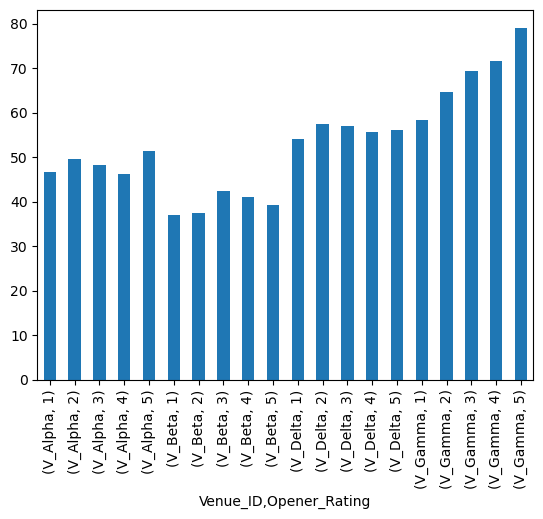

In [541]:
opener_volume = df.groupby(['Venue_ID', 'Opener_Rating'])['Crowd_Energy'].mean()
opener_volume.plot(kind='bar')

### The mosh pit V_Delta FEEDS on itself -
more people means more energy which means more people go crazy which means more energy.
It's exponential. Or linear. Or logarithmic.

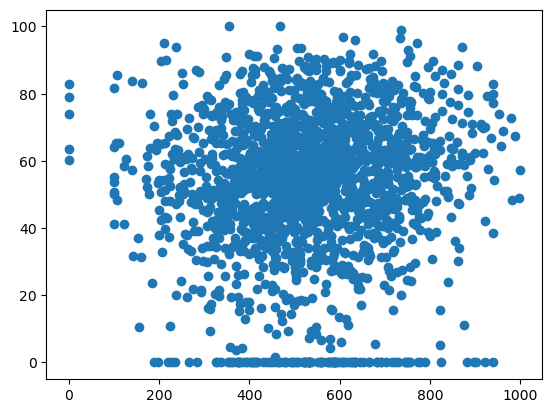

In [542]:
plt.scatter(df['Crowd_Size'],df['Crowd_Energy'])

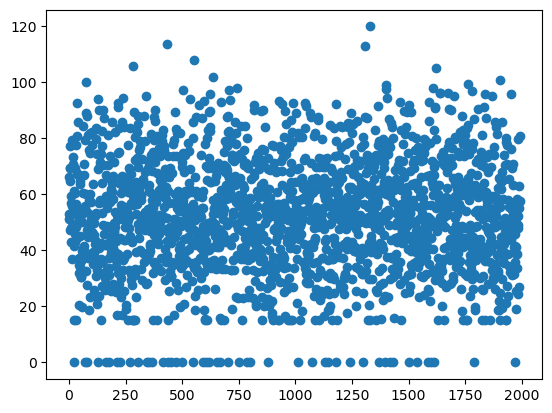

In [543]:
plt.scatter(range(len(df)), df['Ticket_Price_USD'])

### "Time of day matters" 

Avg Crowd Energy grouped by Hour

In [544]:
df['Hour'] = df['Show_DateTime'].dt.hour

C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\3112902927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Show_DateTime'].dt.hour


In [545]:
df.groupby('Hour')['Crowd_Energy'].mean()

Hour
0     41.902391
6      0.000000
7      0.000000
8      0.000000
9      6.822667
10     4.702222
11     3.097000
12    22.908125
13    37.249286
14    52.169091
15    56.286111
16    58.887228
17    56.873025
18    55.113351
19    57.887417
20    56.389300
21    56.316948
22    56.521784
23    57.349937
Name: Crowd_Energy, dtype: float64

Speaking of the goths - they ONLY come alive at night. Or wait, is that
obvious? Every venue is better at night, right? Actually no, I remember
a killer afternoon show somewhere. Was it the mosh pit? The monastery?
I genuinely don't remember.
#### ANALYSIS
YES - GOTHS (V_Beta) REALY DO COME ALIVE AT NIGHT  
KILLER AFTERNOON SHOW - Snob Pit(V_Gamma) -71 avg crowd energy

hence if we look at it altogether , At Night Times 20-23 ,the Energy is highest

In [546]:
hour_energy =df.groupby(['Venue_ID','Hour'])['Crowd_Energy'].mean()
hour_energy

Venue_ID  Hour
V_Alpha   10      51.830000
          12      76.570000
          13      41.264444
          14      46.338333
          15      42.026111
          16      49.344828
          17      46.139107
          18      44.386000
          19      52.600548
          20      51.585254
          21      47.471731
          22      47.572549
          23      50.206389
V_Beta    0       41.902391
          6        0.000000
          7        0.000000
          8        0.000000
          9        0.000000
          10       0.000000
          11       0.762632
          12       2.933636
          13       9.319000
          14      19.584444
          15      15.514286
          16      40.265000
          17      42.077500
          18      47.641429
          19      50.139200
          20      52.406383
          21      54.138000
          22      54.493415
          23      57.327582
V_Delta   9       51.170000
          10      56.900000
          11      47.450000
     

<Axes: xlabel='Venue_ID,Hour'>

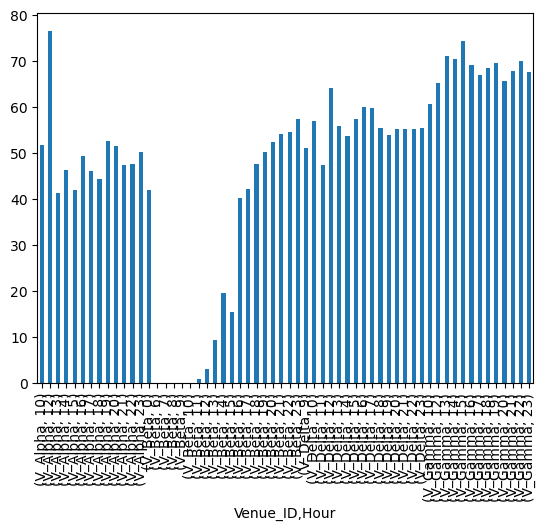

In [547]:
hour_energy.plot(kind='bar')

In [548]:
for v in df['Venue_ID'].unique():
    print(v,df[df['Venue_ID'] == v]['Volume_Level'].corr(subset['Crowd_Energy']))


V_Alpha nan
V_Beta nan
V_Delta nan
V_Gamma 0.0005120371604844823


### PRICING STRATEGY NOTES (I think this was for the snobs? Or the mosh pit?)

45 dollars → they laughed at us. Actually booed. Threw a shoe.\
55 dollars → mixed reactions, some dancing, some sneering\
62 dollars → this felt like a sweet spot? Or was this a different venue?\
80 dollars → definitely worked somewhere. Standing ovation. Or was that the 
             night we had the pyrotechnics malfunction and everyone thought
             it was part of the show? 

The problem is I can't remember WHICH venue had the pricing sensitivity.
I want to say it was V_Gamma because they're snobs. But the mosh pit 
kids are broke, so maybe THEY'RE the price sensitive ones? Or maybe it's 
the monastery - monks probably care about value for money?


C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\2248675251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price_Range'] = pd.cut(df['Ticket_Price_USD'], bins=[0, 40, 50, 60, 70, 90, 150], labels=['<$40', '$45 Range', '$55 Range', '$62 Range', '$80 Range', '>$90'])
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\2248675251.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_pivot = df.groupby(['Venue_ID', 'Price_Range'])['Crowd_Energy'].mean().unstack()


<Axes: xlabel='Price_Range', ylabel='Venue_ID'>

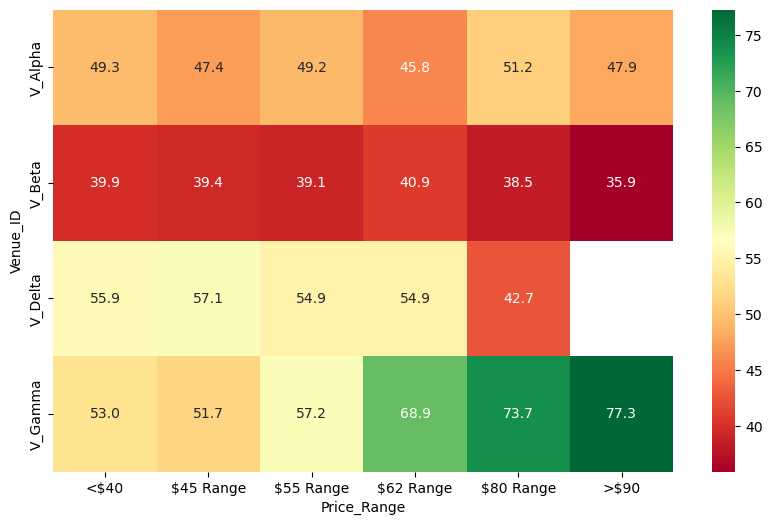

In [549]:
df['Price_Range'] = pd.cut(df['Ticket_Price_USD'], bins=[0, 40, 50, 60, 70, 90, 150], labels=['<$40', '$45 Range', '$55 Range', '$62 Range', '$80 Range', '>$90'])

price_pivot = df.groupby(['Venue_ID', 'Price_Range'])['Crowd_Energy'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(price_pivot, annot=True, cmap='RdYlGn', fmt=".1f")

In [550]:
df.drop(columns=['Price_Range'], inplace=True)

C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\862971791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Price_Range'], inplace=True)


In [551]:
#Dark Green = High Energy, Red = Low Energy.

### CONTRADICTIONS I NEED TO RESOLVE:

##### "Weekends are always better" vs "That Tuesday in London was fire"
#####   → Are weekends USUALLY better or ALWAYS better?
Only at V_Beta Tue was last second in terms of avg crowd energy elsewhere it was avg/ above avg 
   
##### "Price sensitivity is at V_Gamma" vs "I remember a pricing thing at V_Delta"
#####   → Who actually cares about price? Everyone? Just snobs?
At V_Gamma ,As price increases energy increases they view it as exclusive. At V_Delta when we reach the ~80 dollar range energy drops 
        
##### "Timing matters for goths" vs "Every venue has timing preferences"
#####   → Is V_Beta special or am I generalizing?
In V_Beta There is a huge difference in energy b/w night times and day times although other venues also have these they are not as big as goths while timing matters for every venue but if we had to say by singers perspective the diff in other venues wont be as much noticed as in goths 
        
##### "Moon phase is real" vs "The drummer says I'm crazy"
#####   → VERIFY THIS. Prove him wrong.
For most venues max avg crowd energy is at Waxing/waning gibbous phase .The drummer is most
        
##### 6. "Weather affects energy" vs "Weather affects MY mood"
#####   → Control for my mood somehow? Oh wait, you can't. Never mind.
We analyze by venue , At V_Gamma weather doesnt matter that much ,Cloudy has most avg crowd energy at Beta and Alpha,CLear has most at Delta
        

### Random observations (reliability: low)
→ The velvet outfits are NEW. We just started wearing them last month. 
  Might not even be in the historical data yet. They feel lucky though.
→ Weekends are better. I think. At all venues? Or just some?

→ The merch guy, Eddie, tracks post-show sales obsessively. Says there's 
  a correlation with energy. High energy = high sales. Obvious, right? 
  But I don't see how knowing what merch sold AFTER the show helps you 
  PREDICT energy BEFORE the show. He's a nice guy but not a data scientist.
  
→ I keep a log of Volume_Level on my amp. Goes from 1-11 (Spinal Tap 
  reference, obviously). But sometimes the readings glitch out. When we 
  push it too hard at certain venues, the sensor just shows NaN or 
  zeros out. Something about power feedback? The sound guy tried to 
  explain but I wasn't listening.
  
→ Different venues have OPPOSITE reactions to the same thing. What 
  works at one place bombs at another. Maybe train separate models? 
  Or one big model with venue as a feature? I don't know, I'm a singer.


# Feature Engineering

In [552]:
# We wont create features using Merch sales post show and crowd size as they are columns which cause leakage

In [553]:
df['Time_Of_Day'] = ""

for i in df.index:
    hour = df.at[i, 'Show_DateTime'].hour
    if 5 <=hour< 12:
        df.at[i, 'Time_Of_Day'] = 'Morning'
    elif 12 <=hour< 17:
        df.at[i,'Time_Of_Day'] = 'Afternoon'
    elif 17 <=hour < 21:
        df.at[i,'Time_Of_Day'] = 'Evening'
    else:
        df.at[i,'Time_Of_Day'] = 'Night'

C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\4267905362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_Of_Day'] = ""


In [554]:
# Hour & weekday already created 

# Model Training

In [555]:
df.columns

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show', 'Crowd_Energy',
       'Show_DateTime_real', 'Ticket_Price_original', 'Ticket_Price_USD',
       'weekday', 'Hour', 'Time_Of_Day'],
      dtype='object')

In [556]:
y = df['Crowd_Energy']
drop_cols = ['Show_DateTime','Show_DateTime_real','Day_of_Week','Ticket_Price','Ticket_Price_original','Crowd_Size','Merch_Sales_Post_Show']
X = df.drop(columns=drop_cols + ['Crowd_Energy'])



In [558]:
cat_cols = ['Venue_ID','Weather','Moon_Phase','Band_Outfit','weekday','Time_Of_Day']
num_cols = ['Volume_Level','Opener_Rating','Hour']

In [559]:
df.columns

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show', 'Crowd_Energy',
       'Show_DateTime_real', 'Ticket_Price_original', 'Ticket_Price_USD',
       'weekday', 'Hour', 'Time_Of_Day'],
      dtype='object')

In [569]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [563]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols),('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

In [564]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
lr_model = Pipeline(steps=[('preprocess', preprocessor),('model', LinearRegression())])
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Volume_Level',
                                                   'Opener_Rating', 'Hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Venue_ID', 'Weather',
                                                   'Moon_Phase', 'Band_Outfit',
                                                   'weekday',
                                                   'Time_Of_Day'])])),
                ('model', LinearRegression())])

In [565]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = lr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R²:", r2)

RMSE: 15.350262306386478
R²: 0.43757474223273685


In [566]:
# 43% is not great hence our relationship is not linear

In [568]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gb_model = Pipeline([('preprocess', preprocessor),('model', GradientBoostingRegressor(random_state=42))])
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Gradient Boosting RMSE:", rmse)
print("Gradient Boosting R²:", r2)

Gradient Boosting RMSE: 13.665410352335629
Gradient Boosting R²: 0.5542631201604746


In [567]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import numpy as np
gb_tune_pipe = Pipeline([('preprocess', preprocessor),('model', GradientBoostingRegressor(random_state=42))])
param_grid = {'model__n_estimators': [50, 100, 200, 300],'model__learning_rate': [0.01, 0.05, 0.1, 0.2],'model__max_depth': [2, 3, 5],'model__min_samples_split': [2, 5, 10],'model__min_samples_leaf': [1, 2, 4]}
grid = GridSearchCV(gb_tune_pipe,param_grid,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)
grid.fit(X_train, y_train)
print("Best CV RMSE:", -grid.best_score_)
print("Best Params:", grid.best_params_)

Best CV RMSE: 14.32427015734162
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [590]:
from sklearn.ensemble import RandomForestRegressor
rf_model = Pipeline(steps=[('preprocess', preprocessor),('model', RandomForestRegressor(random_state=42))])
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R square:", r2)

RMSE: 13.930518818361845
R square: 0.536800804596081


### Hyperparameter Tuning

In [570]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

rf_tune_pipe = Pipeline([('preprocess', preprocessor),('model', RandomForestRegressor(random_state=42))])
param_grid_rf = {'model__n_estimators': [200, 300, 500],   'model__max_depth': [6, 8, 10, 12],      'model__min_samples_split': [10, 15, 20], 'model__min_samples_leaf': [3, 5, 7]   }
grid_rf = GridSearchCV(rf_tune_pipe,param_grid_rf,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best RF CV RMSE:", -grid_rf.best_score_)
print("Best RF Params:", grid_rf.best_params_)

Best RF CV RMSE: 14.379100955886468
Best RF Params: {'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__min_samples_split': 15, 'model__n_estimators': 500}


In [593]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import numpy as np
tuned_rf_model = Pipeline([('preprocess', preprocessor),('model', RandomForestRegressor(n_estimators=500,max_depth=8,min_samples_split=10,min_samples_leaf=3,random_state=42))])
tuned_rf_model.fit(X_train, y_train)
preds = tuned_rf_model.predict(X_test)
rmse = np.sqrt(((preds - y_test)**2).mean())
r2 = tuned_rf_model.score(X_test, y_test)
print("Tuned RF Test RMSE:", rmse)
print("Tuned RF Test R square:", r2)


Tuned RF Test RMSE: 13.457302305659796
Tuned RF Test R square: 0.5677358378535218


In [571]:
# Train final model on the full training split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
final_model = Pipeline([('preprocess', preprocessor),('model', RandomForestRegressor( n_estimators=300,max_depth=8,min_samples_split=10,min_samples_leaf=3,random_state=42))])
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Volume_Level',
                                                   'Opener_Rating', 'Hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Venue_ID', 'Weather',
                                                   'Moon_Phase', 'Band_Outfit',
                                                   'weekday',
                                                   'Time_Of_Day'])])),
                ('model',
                 RandomForestRegressor(max_depth=8, min_samples_leaf=3,
                                       min_samples_split=10, n_estimators=300,
                                       random_state=42))])

In [573]:
df_test = pd.read_csv('tour_logs_test_input.csv')

In [574]:
df_test['Show_DateTime_real'] = df_test['Show_DateTime'].copy()

for i in df_test.index:
    DateTime = str(df_test.loc[i, 'Show_DateTime_real'])
    
    try:
        df_test.loc[i, 'Show_DateTime'] = pd.to_datetime(DateTime)
    except:
        try:
            df_test.loc[i, 'Show_DateTime'] = pd.to_datetime(DateTime, format='%d/%m/%Y %I:%M %p')
        except:
            try:
                df_test.loc[i, 'Show_DateTime'] = pd.to_datetime(DateTime, format='%m-%d-%Y %H:%M')
            except:
                try:
                    df_test.loc[i, 'Show_DateTime'] = pd.to_datetime(DateTime, format='%B %d, %Y')
                except:
                    if 'late night' in DateTime.lower():
                        df_test.loc[i, 'Show_DateTime'] = pd.to_datetime('2024-06-01 23:00:00')
                    elif 'evening' in DateTime.lower():
                        df_test.loc[i, 'Show_DateTime'] = pd.to_datetime('2024-06-01 20:00:00')
                    elif 'afternoon' in DateTime.lower():
                        df_test.loc[i, 'Show_DateTime'] = pd.to_datetime('2024-06-01 15:00:00')
                    elif 'morning' in DateTime.lower():
                        df_test.loc[i, 'Show_DateTime'] = pd.to_datetime('2024-06-01 10:00:00')


C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\2825880484.py:7: UserWarning: Parsing dates in %d/%m/%Y %I:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_test.loc[i, 'Show_DateTime'] = pd.to_datetime(DateTime)
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\2825880484.py:7: UserWarning: Parsing dates in %d/%m/%Y %I:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_test.loc[i, 'Show_DateTime'] = pd.to_datetime(DateTime)
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\2825880484.py:7: UserWarning: Parsing dates in %d/%m/%Y %I:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_test.loc[i, 'Show_DateTime'] = pd.to_datetime(DateTime)
C:\Users\LOQ\AppData\Local\Temp\ipykernel_24120\2825880484.py:7: UserWarning: Parsing dates in %d/%m/%Y %I:%M %p

In [575]:
# Convert to datetime
df_test['Show_DateTime'] = pd.to_datetime(df_test['Show_DateTime'], errors='coerce')
# extract weekday
df_test['weekday'] = df_test['Show_DateTime'].dt.day_name()

In [576]:
df_test['Hour'] = df_test['Show_DateTime'].dt.hour

In [577]:
# initialize new column 
df_test['Time_Of_Day'] = ""
for i in df_test.index:
    hour = df_test.at[i, 'Show_DateTime'].hour
    if 5 <=hour<12:
        df_test.at[i, 'Time_Of_Day'] = 'Morning'
    elif 12 <=hour< 17:
        df_test.at[i,'Time_Of_Day'] = 'Afternoon'
    elif 17 <=hour< 21:
        df_test.at[i,'Time_Of_Day'] = 'Evening'
    else:
        df_test.at[i,'Time_Of_Day'] = 'Night'

In [578]:
df_test['Ticket_Price_original'] = df_test['Ticket_Price']
prices = []
for price in df_test['Ticket_Price']:
    if pd.isna(price):
        prices.append(None)
        continue
    price_str = str(price).strip().lower()
    if 'free' in price_str:
        prices.append(0)
        continue
    numbers = re.findall(r'\d+\.?\d*', price_str)
    if not numbers:
        prices.append(None)
        continue
    
    value = float(numbers[0])    
    if '£' in price_str:
        prices.append(value * 1.27)
    elif '€' in price_str:
        prices.append(value * 1.09)
    else:
        prices.append(value)
df_test['Ticket_Price_USD'] = prices

In [579]:
df_test.columns

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show', 'Show_DateTime_real', 'weekday',
       'Hour', 'Time_Of_Day', 'Ticket_Price_original', 'Ticket_Price_USD'],
      dtype='object')

In [580]:
# volume level 
df_test.loc[df_test['Volume_Level'] <= 0, 'Volume_Level'] = np.nan
df_test.loc[df_test['Volume_Level'] > 11, 'Volume_Level'] = np.nan

In [581]:
venue = df_test['Venue_ID'].unique()
for v in venue:
    m = df_test[df_test['Venue_ID']==v]['Volume_Level'].median()
    df_test.loc[df_test['Venue_ID']==v,'Volume_Level'] = df_test.loc[df_test['Venue_ID']==v,'Volume_Level'].fillna(m)


In [582]:
# Crowd size 
df_test.loc[df_test['Crowd_Size'] < 0,'Crowd_Size'] = np.nan
df_test.loc[df_test['Crowd_Size'] > 1000,'Crowd_Size'] = np.nan

In [583]:
venue = df_test['Venue_ID'].unique()
for v in venue:
    m = df_test[df_test['Venue_ID']==v]['Crowd_Size'].median()
    df_test.loc[df_test['Venue_ID']==v,'Crowd_Size'] = df_test.loc[df_test['Venue_ID']==v,'Crowd_Size'].fillna(m)

In [584]:
df_test.isna().sum()

Gig_ID                   0
Venue_ID                 0
Show_DateTime            0
Day_of_Week              0
Volume_Level             0
Ticket_Price             0
Crowd_Size               0
Opener_Rating            0
Weather                  0
Moon_Phase               0
Band_Outfit              0
Merch_Sales_Post_Show    0
Show_DateTime_real       0
weekday                  0
Hour                     0
Time_Of_Day              0
Ticket_Price_original    0
Ticket_Price_USD         0
dtype: int64

In [585]:
df.columns

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show', 'Crowd_Energy',
       'Show_DateTime_real', 'Ticket_Price_original', 'Ticket_Price_USD',
       'weekday', 'Hour', 'Time_Of_Day'],
      dtype='object')

In [586]:
df_test.columns

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show', 'Show_DateTime_real', 'weekday',
       'Hour', 'Time_Of_Day', 'Ticket_Price_original', 'Ticket_Price_USD'],
      dtype='object')

In [587]:
df.columns

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show', 'Crowd_Energy',
       'Show_DateTime_real', 'Ticket_Price_original', 'Ticket_Price_USD',
       'weekday', 'Hour', 'Time_Of_Day'],
      dtype='object')

In [588]:
# ['Gig_ID', 'Venue_ID', 'Volume_Level', 'Opener_Rating', 'Weather',
# 'Moon_Phase', 'Band_Outfit', 'weekday', 'Hour', 'Time_Of_Day',
# 'Ticket_Price_USD', 'Crowd_Size']


In [589]:
df_test2 = df_test.copy()

cols = ['Gig_ID','Venue_ID','Volume_Level','Opener_Rating','Weather','Moon_Phase','Band_Outfit','weekday','Hour','Time_Of_Day','Crowd_Size','Ticket_Price_USD']
df_test2 = df_test2[cols]

test_preds = final_model.predict(df_test2)

final = pd.DataFrame({'Gig_ID': df_test2['Gig_ID'],'Crowd_Energy': test_preds})

final.to_csv('predictions.csv', index=False)

